# Leila Shafizadeh Biomedical Data Science Capstone Project #
## Fall 2025 ##

### My objective with this project is to use the CDC's publicly available <u>Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System</u> dataset to explore and compare the relationship between obesity, inactivity, and income.

#### [Link to dataset](https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Behavioral/hn4x-zwk7/about_data)

### Part 1: Cleaning and Shaping ###

#### The first step is to load and clean the data. I loaded the dataset from my desktop and performed basic cleaning to make sure that only the relevant data is kept for analysis. I filtered the dataset by year to keep it recent (2021-2025) and focused on relevant factors like obesity, leisure-time physical activity, income, and education. I also converted data columns to numeric, dropped missing values, and only kept data that had a high enough sample size and was from the contiguous 50 states (ie excluded territories).


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# loading CSV file
file_path = '/Users/Leila/Desktop/Nutrition_Physical_Activity_Obesity.csv'
df = pd.read_csv(file_path)

"""
in the csv there were a lot of column name inconsistencies I had to handle which were giving a lot of errors, 
so I had to try different possible naming conventions for each variable. for example, I found that 'High_Confidence_Limit
had a trailing zero that was hard to find which was giving me a lot of errors.
"""

if 'High_Confidence_Limit' in df.columns:
    high_conf_col = 'High_Confidence_Limit'
elif 'High_Confidence_Limit0' in df.columns:
    high_conf_col = 'High_Confidence_Limit0'
else:
    high_conf_col = None

if 'Low_Confidence_Limit' in df.columns:
    low_conf_col = 'Low_Confidence_Limit'
elif 'Low_Confidence_Limit0' in df.columns:
    low_conf_col = 'Low_Confidence_Limit0'
else:
    low_conf_col = None

sample_col = 'Sample_Size' if 'Sample_Size' in df.columns else (
    'Sample Size' if 'Sample Size' in df.columns else None
)

# filter by year (2021–2025) and by relevant questions
# Q036 = Obesity, Q047 = No leisure-time physical activity
df['YearStart'] = pd.to_numeric(df['YearStart'], errors='coerce')
df = df[(df['YearStart'] >= 2021) & (df['YearStart'] <= 2025)]
df = df[df['QuestionID'].isin(['Q036', 'Q047'])]

# keep relevant population groups. I'm focused on Total, Income, and Education categories.
df = df[df['StratificationCategory1'].isin(['Total', 'Income', 'Education'])]

# convert data columns to numeric and drop missing values
df['Data_Value'] = pd.to_numeric(df['Data_Value'], errors='coerce')
df = df.dropna(subset=['Data_Value'])

if low_conf_col:
    df[low_conf_col] = pd.to_numeric(df[low_conf_col], errors='coerce')
if high_conf_col:
    df[high_conf_col] = pd.to_numeric(df[high_conf_col], errors='coerce')

# clean and filter by sample size for reliability
if sample_col:
    df[sample_col] = pd.to_numeric(df[sample_col].astype(str).str.replace(',', ''), errors='coerce')
    df = df[df[sample_col] >= 100]

# exclude territories (for consistent mainland comparisons)
df = df[~df['LocationAbbr'].isin(['GU', 'PR', 'VI'])]

print(f"data is loaded and cleaned")

data is loaded and cleaned


#### Then I reshaped the data so each row has both obesity and inactivity percentages for the same group/year so it can be used to make relevant conclusions.

In [66]:
# each row = (Year, State, StratificationCategory, StratificationGroup)
# columns = Obesity (%) and Inactivity (%) for comparison
df_pivot = (
    df.pivot_table(
        index=['YearStart', 'LocationAbbr', 'StratificationCategory1', 'Stratification1'],
        columns='QuestionID',
        values='Data_Value'
    )
    .reset_index()
    .rename(columns={'Q036': 'Obesity_Pct', 'Q047': 'Inactivity_Pct'})
)

# drop incomplete rows
df_pivot = df_pivot.dropna(subset=['Obesity_Pct', 'Inactivity_Pct'])

print("pivoted data ready for analysis")

pivoted data ready for analysis


### Part 2: Graphing and Exploratory Data Analysis ### 
#### This first graph is a scatter plot to explore the relationship between obesity and lack of physical activity.

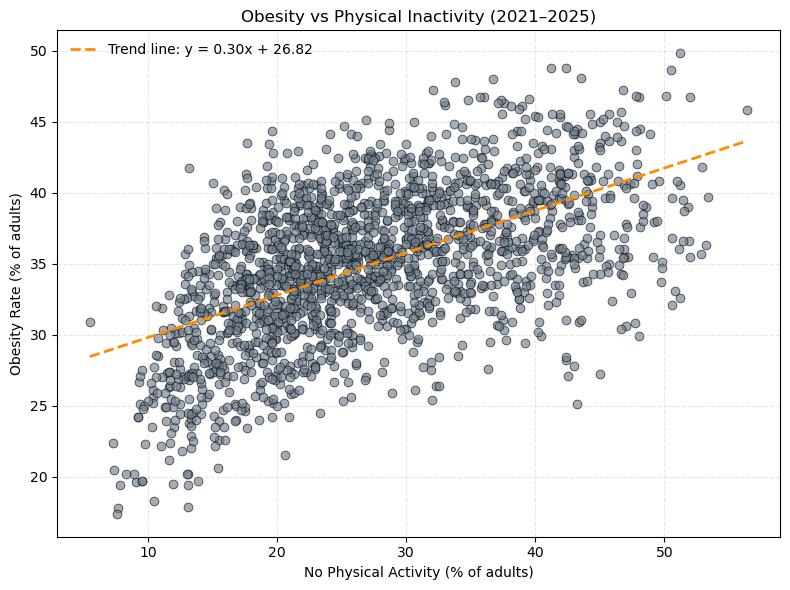

Correlation between inactivity and obesity: 0.559.
A positive correlation indicates that higher inactivity generally corresponds to higher obesity rates.


In [80]:
import matplotlib.pyplot as plt
import numpy as np

# select data and ensure it's numeric
x = df_pivot['Inactivity_Pct'].astype(float)
y = df_pivot['Obesity_Pct'].astype(float)

# create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.65, s=40, color='slategray', edgecolor='black', linewidth=0.6)

# add linear fit (trend) line if data available
mask = ~np.isnan(x) & ~np.isnan(y)
if mask.sum() > 1:
    m, b = np.polyfit(x[mask], y[mask], 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_line, m*x_line + b, '--', color='darkorange', linewidth=2,
             label=f'Trend line: y = {m:.2f}x + {b:.2f}')

# formatting the plot
plt.xlabel('No Physical Activity (% of adults)', fontsize=10)
plt.ylabel('Obesity Rate (% of adults)', fontsize=10)
plt.title('Obesity vs Physical Inactivity (2021–2025)', fontsize=12, fontweight='normal')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# display correlation coefficient for clarity
corr = np.corrcoef(x[mask], y[mask])[0, 1]
print(f"Correlation between inactivity and obesity: {corr:.3f}.")
print("A positive correlation indicates that higher inactivity generally corresponds to higher obesity rates.")

This second plot is a bar chart that explores the relationship between obesity and income group.

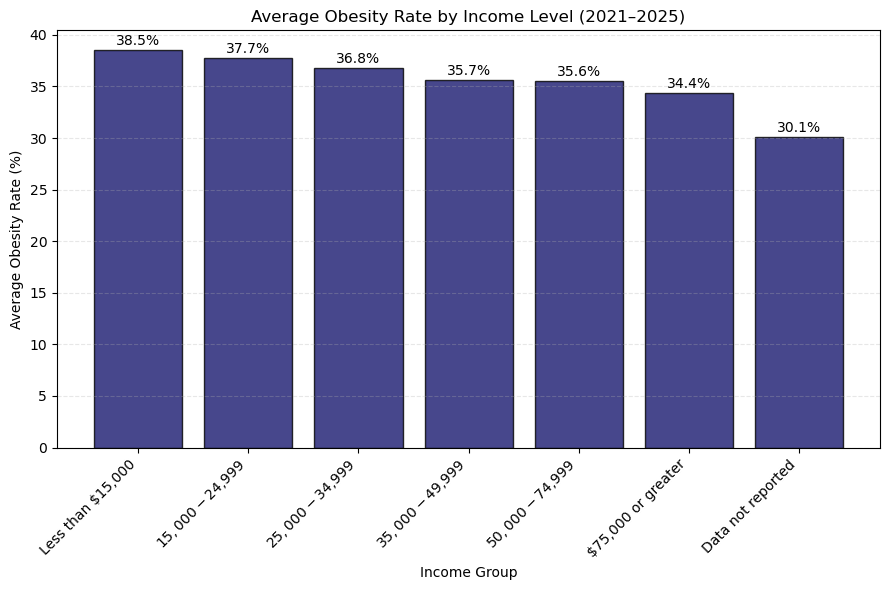

Lower-income groups typically show higher average obesity rates, suggesting a socioeconomic gradient in obesity prevalence.


In [68]:
# Focus on income-stratified records
income_df = df_pivot[df_pivot['StratificationCategory1'] == 'Income']

if not income_df.empty:
    # compute mean obesity by income group
    avg_by_income = (
        income_df.groupby('Stratification1')['Obesity_Pct']
        .mean()
        .reset_index()
        .sort_values(by='Obesity_Pct', ascending=False)
    )

    # create bar chart
    plt.figure(figsize=(9, 6))
    bars = plt.bar(avg_by_income['Stratification1'], avg_by_income['Obesity_Pct'],
                   color='midnightblue', edgecolor='black', alpha=0.8)

    # add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,
                 f"{height:.1f}%", ha='center', va='bottom', fontsize=10)

    # formatting
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Obesity Rate (%)', fontsize=10)
    plt.xlabel('Income Group', fontsize=10)
    plt.title('Average Obesity Rate by Income Level (2021–2025)', fontsize=12, fontweight='normal')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # results
    print("Lower-income groups typically show higher average obesity rates, suggesting a socioeconomic gradient in obesity prevalence.")
else:
    print("No income-stratified data available for visualization.")

### Part 3: Regression Analysis

#### Since I was able to show that obesity is linked to both income and inactivity, I did a regression analysis to try to figure out which factor was a greater indicator of obesity overall. I started by analyzing each model separately then comparing the results.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# start by preparing the data

# convert numbers safely and remove missing data
df_pivot['Obesity_Pct'] = pd.to_numeric(df_pivot['Obesity_Pct'], errors='coerce')
df_pivot['Inactivity_Pct'] = pd.to_numeric(df_pivot['Inactivity_Pct'], errors='coerce')

# for the income data, make sure we only take rows that have income info
income_df = df_pivot[df_pivot['StratificationCategory1'] == 'Income'].copy()

# convert the income categories into simple numeric codes
if not income_df.empty:
    income_df['Income_Code'] = income_df['Stratification1'].astype('category').cat.codes
else:
    print("No income data found, skipping income model.")

# then analyze each model separately, starting with Inactivity vs Obesity

# clean the data for this model
x1 = df_pivot['Inactivity_Pct'].dropna().values.reshape(-1, 1)
y1 = df_pivot['Obesity_Pct'].dropna().values

# split data into training and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

# make and train the model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

# predict on test data
y1_pred = model1.predict(X1_test)

# calculate R² score (how good the model is)
r2_inact = r2_score(y1_test, y1_pred)

print("Inactivity vs Obesity")
print(f"Equation: Obesity = {model1.intercept_:.2f} + {model1.coef_[0]:.2f} × Inactivity")
print(f"R² score: {r2_inact:.3f}")
print()

# repeat for Income vs Obesity

if not income_df.empty:
    x2 = income_df['Income_Code'].dropna().values.reshape(-1, 1)
    y2 = income_df['Obesity_Pct'].dropna().values

    X2_train, X2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

    model2 = LinearRegression()
    model2.fit(X2_train, y2_train)

    y2_pred = model2.predict(X2_test)

    r2_income = r2_score(y2_test, y2_pred)

    print("Income vs Obesity")
    print(f"Equation: Obesity = {model2.intercept_:.2f} + {model2.coef_[0]:.2f} × Income_Level")
    print(f"R² score: {r2_income:.3f}")
    print()
else:
    r2_income = 0

# then compare the results
print("Model Comparison")
if r2_inact > r2_income:
    print(f"Inactivity is a better predictor of obesity (R² = {r2_inact:.3f}) "
          f"than income (R² = {r2_income:.3f}).")
else:
    print(f"Income is a better predictor of obesity (R² = {r2_income:.3f}) "
          f"than inactivity (R² = {r2_inact:.3f}).")
print()
print("The higher the R², the stronger the relationship.")

Inactivity vs Obesity
Equation: Obesity = 26.77 + 0.30 × Inactivity
R² score: 0.291

Income vs Obesity
Equation: Obesity = 36.82 + -0.46 × Income_Level
R² score: 0.018

Model Comparison
Inactivity is a better predictor of obesity (R² = 0.291) than income (R² = 0.018).

The higher the R², the stronger the relationship.


#### To further compare the results I also plotted both models (%test vs %actual obesity):

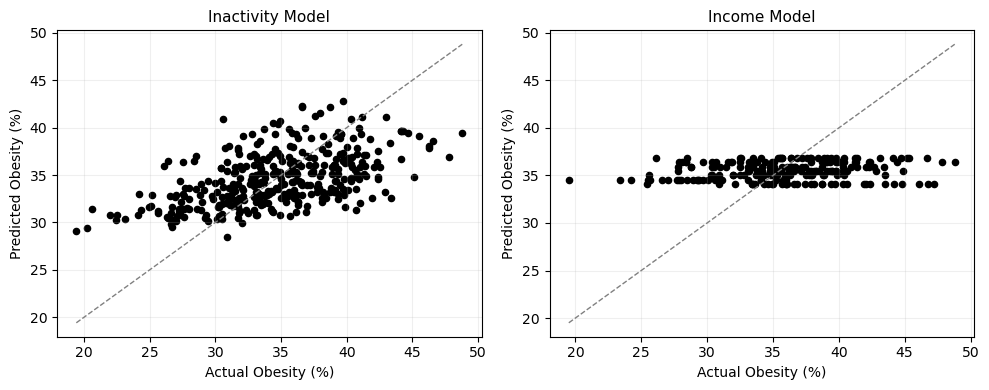


Both models show that obesity is related to inactivity and income, but the shape of the inactivity graph, with points falling
closer along the fit line, shows a stronger relationship compared to the income graph which is more spread out.


In [76]:
plt.figure(figsize=(10, 4))

# plot 1: inactivity model
plt.subplot(1, 2, 1)
plt.scatter(y1_test, y1_pred, s=20, color='black')
plt.plot([min(y1_test), max(y1_test)], [min(y1_test), max(y1_test)], '--', color='gray', linewidth=1)
plt.title("Inactivity Model", fontsize=11)
plt.xlabel("Actual Obesity (%)", fontsize=10)
plt.ylabel("Predicted Obesity (%)", fontsize=10)
plt.grid(alpha=0.2)

# plot 2: income model
if not income_df.empty:
    plt.subplot(1, 2, 2)
    plt.scatter(y2_test, y2_pred, s=20, color='black')
    plt.plot([min(y2_test), max(y2_test)], [min(y2_test), max(y2_test)], '--', color='gray', linewidth=1)
    plt.title("Income Model", fontsize=11)
    plt.xlabel("Actual Obesity (%)", fontsize=10)
    plt.ylabel("Predicted Obesity (%)", fontsize=10)
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# conclusions
print()
print("Both models show that obesity is related to inactivity and income, but the shape of the inactivity graph, with points falling")
print("closer along the fit line, shows a stronger relationship compared to the income graph which is more spread out.")

### Conclusion

#### From these simple regression models, one can see that both physical inactivity and income level have a relationship with obesity rates.  The model using <u>inactivity</u> explains a bit more of the variation in obesity because it has a higher R² and the points on its plot fall much closer to the fit line, which means the model’s predictions are more accurate.  This suggests that how active people are may have a more direct link to obesity than income alone.  

#### However, income still seems to matter as areas or groups with lower income often have higher obesity rates on average.  This could be because income affects access to healthy foods, exercise opportunities, and overall lifestyle.

#### In short, both factors are connected to obesity, but physical inactivity appears to be the stronger single predictor in this dataset.  It’s likely that the two variables also interact in real life: people with lower income might also face more barriers to being physically active.
